# Telluric Fitting with TelFit

This notebook describes how to fit observed data using TelFit. This is a much more involved process than just making a telluric model, so may take a while to run. On my computer, each fit took 1-2 minutes. We will again start with a relatively simple example: fitting the telluric lines in a A-star spectrum.

In [1]:
# import everything we need
import telfit
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

%matplotlib inline


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Lets first take a look at the raw data.

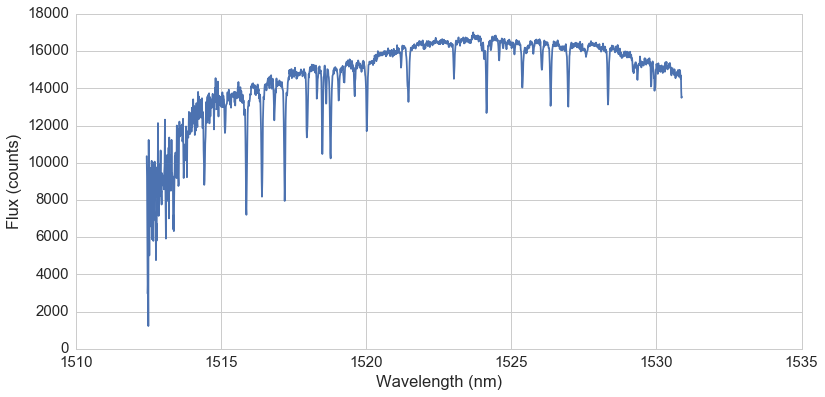

In [2]:
# Read in the data from a text file
wave, flux = np.loadtxt('../data/sample_data.dat', usecols=(0, 1), unpack=True)

# Convert into the structure that telfit wants
data = telfit.DataStructures.xypoint(x=wave, y=flux)

fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(data.x, data.y)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Flux (counts)')

This is one echelle order from the spectrum of a A-star, so all of the sharp features are telluric lines. We are going to use TelFit to fit this data. The basic steps are:

1. Initialize the fitter
2. Tell the fitter about the pressure, temperature etc. I don't usually fit those since they are well known at the observatory, but telfit needs to know what they are.
3. Tell the fitter about the variables you want to fit, and give initial guesses and bounds.

In [3]:
# Instantiate the fitter class
fitter = telfit.TelluricFitter()

# Set the observatory. McDonald and a few others are available by name.
fitter.SetObservatory('McDonald')

# Set a bunch of parameters that exist as fits header keywords in most cases (IGRINS being a notable exception...)
RH = 29.4     # Relative humidity
T = 61.6      # Temperature, in Fahrenheit
P = 23.5815   # Pressure in mm Hg
ZD = 22.86619 # Zenith distance in degrees

# Tell TelFit about these parameters
fitter.AdjustValue(dict(temperature=(T - 32.0) * 5.0 / 9.0 + 273.15,
                        pressure=P*33.77, angle=ZD,
                        wavestart=data.x[0]-5.0,
                        waveend=data.x[-1]+5.0))

# Tell Telfit to fit the humidity
fitter.FitVariable(dict(h2o=RH))
fitter.SetBounds(dict(h2o=(1, 99), resolution=(30000, 50000)))



In [4]:
# Finally, perform the fit
source, model = fitter.Fit(data=data,                   # The data to fit
                           resolution_fit_mode='SVD',   # This is best for IGRINS data. The other option is 'gauss'
                           adjust_wave='data',          # Adjust the data wavelengths to match the model, rather than vice versa
                           continuum_fit_order=4,       # Fit the continuum with a 4th-order polynomial
                           wavelength_fit_order=3,      # Add a 3rd-order polynomial to the wavelengths
                           air_wave=True,               # The wavelengths are in air (not vacuum)
                           fit_source=True)             # Fit the source spectrum with a smoothing spline

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.94000E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.94000E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.94000E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	3.56747E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.22442E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	3.03892E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.14441E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.97784E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            

(0.9, 1.1)

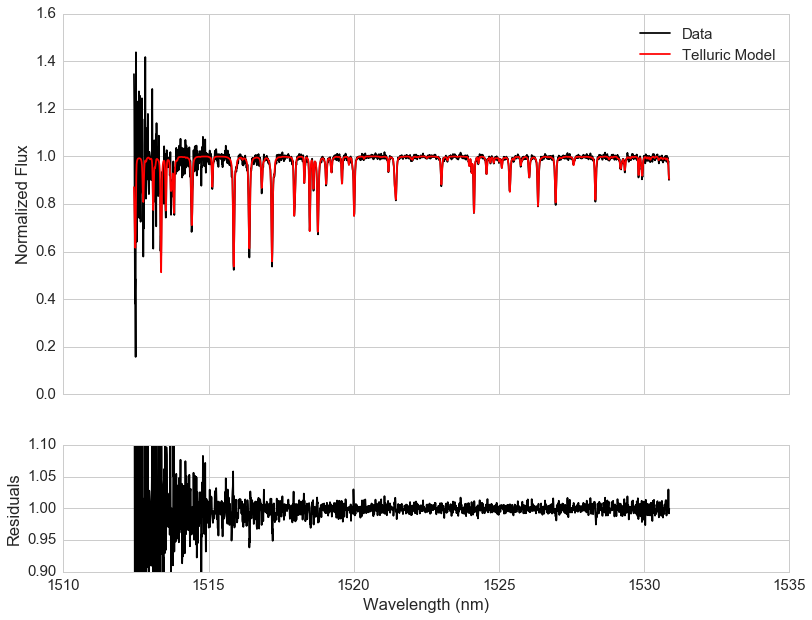

In [5]:
# Get the new data (it has an updated wavelength axis)
newdata = fitter.data

fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13, 10), 
                                  gridspec_kw=dict(height_ratios=(3,1)))

top.plot(newdata.x, newdata.y/newdata.cont, 'k-', label='Data')
top.plot(model.x, model.y, 'r-', label='Telluric Model')
bottom.plot(newdata.x, newdata.y/newdata.cont / model.y, 'k-')

bottom.set_xlabel('Wavelength (nm)')
bottom.set_ylabel('Residuals')
top.set_ylabel('Normalized Flux')

leg = top.legend(loc='best', fancybox=True)

bottom.set_ylim((0.9, 1.1))

## Updating the atmosphere profile

Just like with the modeler class, you can update the atmosphere profile with the GDAS data. It is almost the same code, except we use the fitter instance instead of the modeler instance.

In [6]:
# Read in the atmosphere profile
Pres, height, Temp, dew = np.loadtxt('../data/GDAS_profile.dat',
                                     usecols=(0, 1, 2, 3),
                                     unpack=True)

# Sort the arrays by height.
sorter = np.argsort(height)
height = height[sorter]
Pres = Pres[sorter]
Temp = Temp[sorter]
dew = dew[sorter]

#Convert dew point temperature to ppmv
Pw = 6.116441 * 10**(7.591386*Temp/(Temp + 240.7263))
h2o = Pw / (Pres-Pw) * 1e6

#Unit conversion
height /= 1000.0
Temp += 273.15

# Tell the modeler instance to update the atmosphere profile
fitter.EditAtmosphereProfile('Temperature', height, Temp)
fitter.EditAtmosphereProfile('Pressure', height, Pres)
fitter.EditAtmosphereProfile('H2O', height, h2o)

In [7]:
# Fit again to see the difference in the best-fit models
source, model2 = fitter.Fit(data=data,                   # The data to fit
                            resolution_fit_mode='SVD',   # This is best for IGRINS data. The other option is 'gauss'
                            adjust_wave='data',          # Adjust the data wavelengths to match the model, rather than vice versa
                            continuum_fit_order=4,       # Fit the continuum with a 4th-order polynomial
                            wavelength_fit_order=3,      # Add a 3rd-order polynomial to the wavelengths
                            air_wave=True,               # The wavelengths are in air (not vacuum)
                            fit_source=True)             # Fit the source spectrum with a smoothing spline

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.14065E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.14065E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.14065E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.97496E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	1.38465E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.36644E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	1.35445E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	2.34056E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            

(0.9, 1.1)

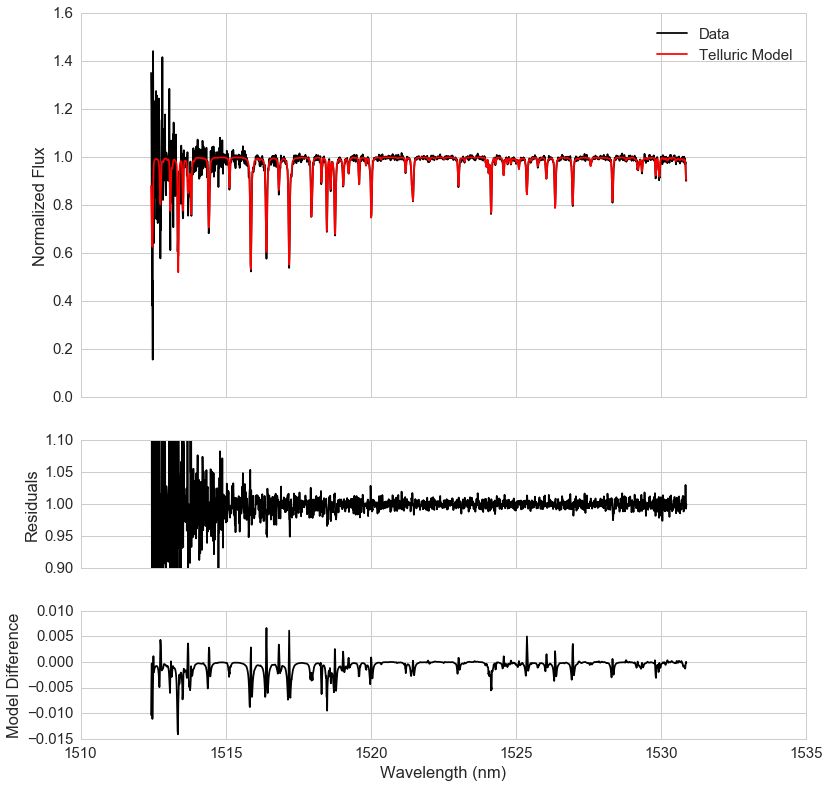

In [8]:
newdata2 = fitter.data
fig, (top, middle, bottom) = plt.subplots(3, 1, sharex=True, figsize=(13, 13), 
                                  gridspec_kw=dict(height_ratios=(3,1, 1)))

top.plot(newdata2.x, newdata2.y/newdata2.cont, 'k-', label='Data')
top.plot(model2.x, model2.y, 'r-', label='Telluric Model')
middle.plot(newdata2.x, newdata2.y/newdata2.cont / model2.y, 'k-')
bottom.plot(model.x, model.y - model2.y, 'k-')

bottom.set_xlabel('Wavelength (nm)')
bottom.set_ylabel('Model Difference')
middle.set_ylabel('Residuals')
top.set_ylabel('Normalized Flux')

leg = top.legend(loc='best', fancybox=True)

middle.set_ylim((0.9, 1.1))

The fit quality is pretty much the same in this example. However, there are pretty big differences between the best-fit models; namely, they have different line profiles. The only reason we don't see much difference in the residuals is because it is a bit too noisy. **If you have high S/N data and are not getting an adequate fit, try updating the atmosphere profile!**

## "What about late-type stars?"

Most of you don't care about A-stars. The objects most of you care about have their own intrinsic spectrum with sharp lines. What to do about that? Well, there are a few options:

1. **Pretend the only lines in the spectrum are telluric lines.** As long as there are a good deal more telluric lines than there are stellar lines, TelFit will generally still do an alright job.

2. **Tell TelFit where the stellar lines are.** You can tell TelFit to ignore certain wavelengths in the $\chi^2$ calculation. This helps if there are stellar lines blended with telluric lines. At the moment, it doesn't ignore those regions when doing wavelength calibration or instrumental profile fitting, so it might still give poor results.

3. **Tell TelFit what the source spectrum looks like.** This is a new and pretty much un-tested feature, but in principle you should be able to give it a function that returns a normalized model spectrum. With near infinite computer time, you could use this to simultaneously fit for the telluric and source spectrum!

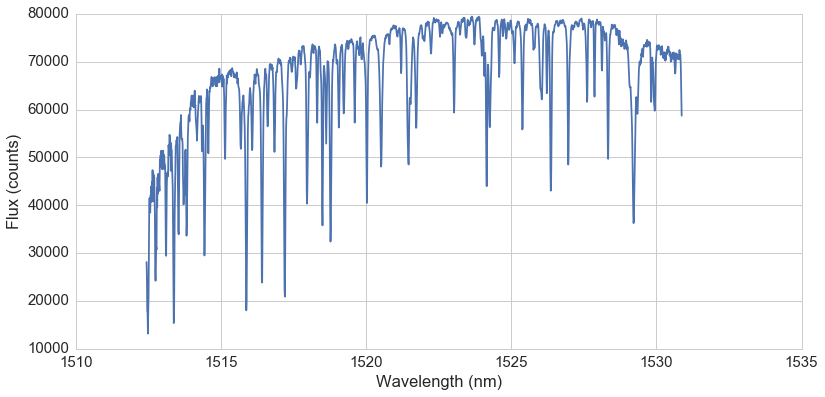

In [9]:
# Read in the data from a text file
wave, flux = np.loadtxt('../data/sample_data2.dat', usecols=(0, 1), unpack=True)

# Convert into the structure that telfit wants
data = telfit.DataStructures.xypoint(x=wave, y=flux)

fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(data.x, data.y)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Flux (counts)')

In [10]:
# Make a new fitter to get back to the default atmosphere profile
fitter = telfit.TelluricFitter()
fitter.SetObservatory('McDonald')

# Update the relevant parameters
RH = 54.0     # Relative humidity
T = 54.1      # Temperature, in Fahrenheit
P = 23.456    # Pressure in mm Hg
ZD = 40.24009 # Zenith distance in degrees

# Tell TelFit about these parameters
fitter.AdjustValue(dict(temperature=(T - 32.0) * 5.0 / 9.0 + 273.15,
                        pressure=P*33.77, angle=ZD,
                        wavestart=data.x[0]-5.0,
                        waveend=data.x[-1]+5.0))

# Tell Telfit to fit the humidity
fitter.FitVariable(dict(h2o=RH))
fitter.SetBounds(dict(h2o=(1, 99), resolution=(30000, 50000)))

In [11]:
# Method 1: Cross your fingers and hope for the best
model = fitter.Fit(data=data,                   # The data to fit
                   resolution_fit_mode='SVD',   # This is best for IGRINS data. The other option is 'gauss'
                   adjust_wave='data',          # Adjust the data wavelengths to match the model, rather than vice versa
                   continuum_fit_order=5,       # Fit the continuum with a 5th-order polynomial
                   wavelength_fit_order=3,      # Add a 3rd-order polynomial to the wavelengths
                   air_wave=True,               # The wavelengths are in air (not vacuum)
                   fit_source=False)            # Do not fit the source spectrum

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.40000E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.40000E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.40000E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.52606E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.03224E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.35118E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.01225E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.01225E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            


-------------	-----		-----		-----
h2o            	6.03224E+01	True		1 - 99


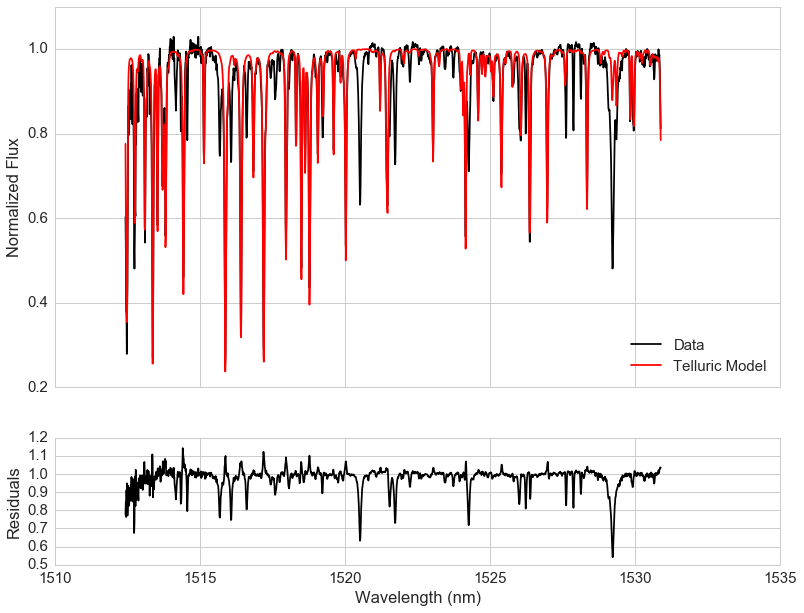

In [12]:
# Get the new data (it has an updated wavelength axis)
newdata = fitter.data

fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13, 10), 
                                  gridspec_kw=dict(height_ratios=(3,1)))

top.plot(newdata.x, newdata.y/newdata.cont, 'k-', label='Data')
top.plot(model.x, model.y, 'r-', label='Telluric Model')
bottom.plot(newdata.x, newdata.y/newdata.cont / model.y, 'k-')

bottom.set_xlabel('Wavelength (nm)')
bottom.set_ylabel('Residuals')
top.set_ylabel('Normalized Flux')

leg = top.legend(loc='best', fancybox=True)

This method sort of works, but there are large and pretty obvious residuals from the telluric fit. The residuals are mostly consistent with an over-correction, and that is largely because of the stellar absorption line near 1529 nm  that coincide with telluric lines. The fitter doesn't know that it is a true source line, and so it tries to increase the humidity to make those water lines deeper. The poor continuum estimation on the blue end of the spectrum has the same effect.

Lets now try telling TelFit to ignore certain wavelength regions in the telluric fit. The figure below shows the residual spectrum, and I have shaded the parts to ignore in red. We are cutting out much of the wavelength space; be careful not to remove too much!

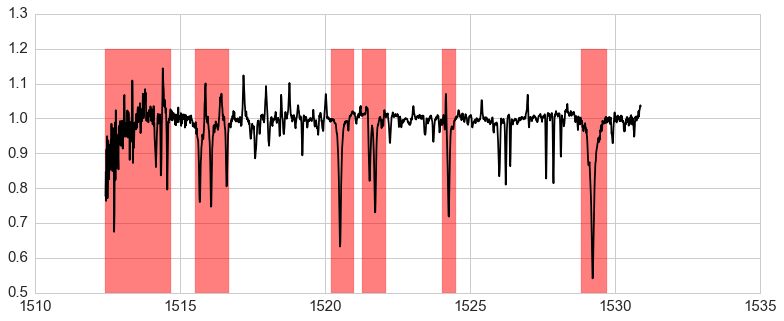

In [13]:
badregions = [[1512, 1514.7],
              [1515.5, 1516.7],
              [1520.2, 1521],
              [1521.25, 1522.1],
              [1524, 1524.5],
              [1528.8, 1529.7]]

resids = newdata.copy()
resids.y = (newdata.y / newdata.cont / model.y)
resids.cont = np.ones_like(resids.x)

plt.figure(figsize=(13,5))
plt.plot(resids.x, resids.y, 'k-')
ylim = plt.ylim()
for region in badregions:
    x = resids.x[(resids.x >= region[0]) & (resids.x <= region[1])]
    plt.fill_between(x, ylim[0], ylim[1], alpha=0.5, color='red')

In [14]:
# Method 2: Ignore the strong stellar lines
fitter.IgnoreRegions(badregions)

# Fit
model2 = fitter.Fit(data=data,                   # The data to fit
                   resolution_fit_mode='SVD',   # This is best for IGRINS data. The other option is 'gauss'
                   adjust_wave='data',          # Adjust the data wavelengths to match the model, rather than vice versa
                   continuum_fit_order=5,       # Fit the continuum with a 5th-order polynomial
                   wavelength_fit_order=3,      # Add a 3rd-order polynomial to the wavelengths
                   air_wave=True,               # The wavelengths are in air (not vacuum)
                   fit_source=False)            # Do not fit the source spectrum


Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.03224E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.03224E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.03224E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	6.35118E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.72357E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55303E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55303E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            


-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99


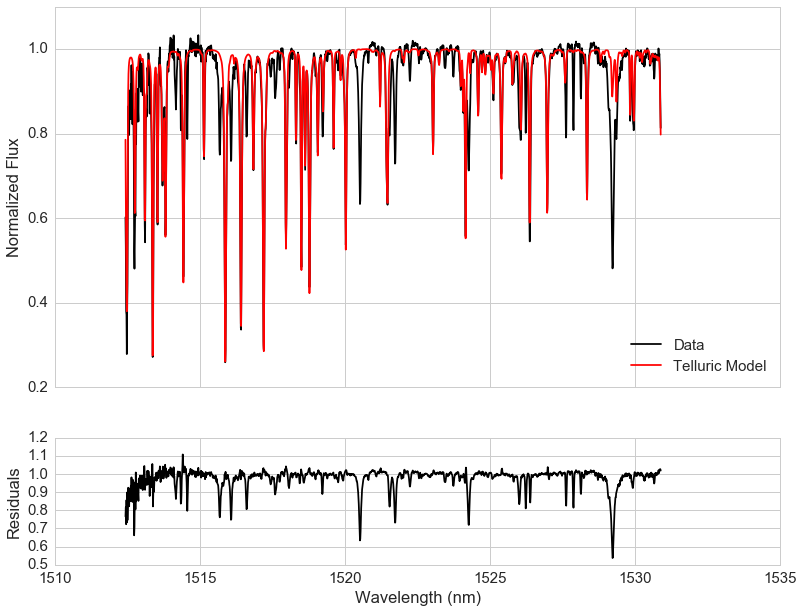

In [15]:
newdata2 = fitter.data

fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13, 10), 
                                  gridspec_kw=dict(height_ratios=(3,1)))

top.plot(newdata2.x, newdata2.y/newdata2.cont, 'k-', label='Data')
top.plot(model2.x, model2.y, 'r-', label='Telluric Model')
bottom.plot(newdata2.x, newdata2.y/newdata2.cont / model2.y, 'k-')
#bottom.plot(newdata.x, newdata.y/newdata.cont / model.y, 'r-', alpha=0.7, lw=0.8)

bottom.set_xlabel('Wavelength (nm)')
bottom.set_ylabel('Residuals')
top.set_ylabel('Normalized Flux')

leg = top.legend(loc='best', fancybox=True)

This is better, but still has some very noticable telluric residuals. Let's try out the new feature by using a model for the source.

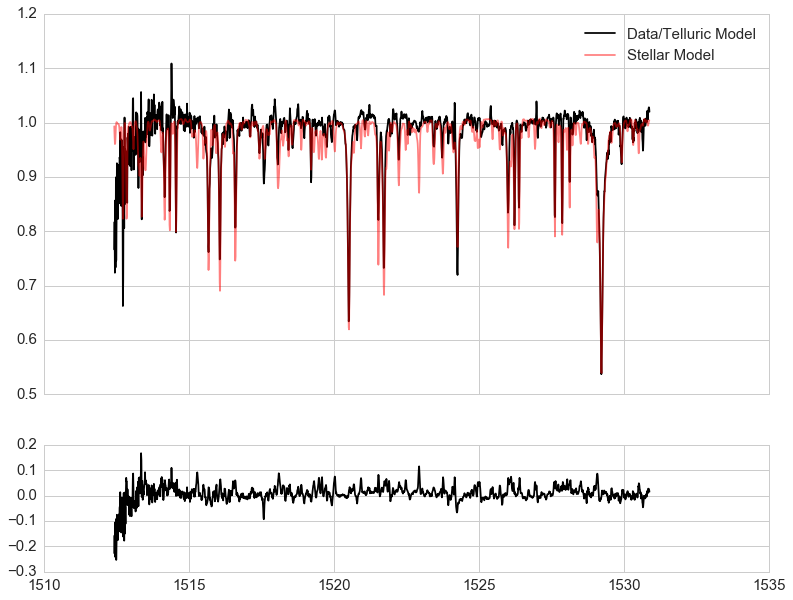

In [16]:
x, y, cont = np.loadtxt('../data/t4500g5.0z0.0a0.0.dat', usecols=(0, 1, 2), unpack=True)
subset = telfit.DataStructures.xypoint(x=x, y=y, cont=cont)


fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13, 10), 
                                  gridspec_kw=dict(height_ratios=(3,1)))

top.plot(newdata2.x, newdata2.y/newdata2.cont / model2.y, 'k-', label='Data/Telluric Model')
top.plot(subset.x, subset.y/subset.cont, 'r-', alpha=0.5, label='Stellar Model')
bottom.plot(newdata2.x, newdata2.y/newdata2.cont / model2.y - subset.y/subset.cont, 'k-')

leg = top.legend(loc='best', fancybox=True)

In [17]:
def source_function(data, *args, **kwargs):
    """ 
    Generates an estimate for the spectrum of the object you are looking at.
    In a more realistic case, this function might fit for the radial velocity 
    star to make sure the model lines up with the data. It could even fit
    for the stellar parameters (Teff, logg, [Fe/H]), but that would take a very
    long time to run. This function get called on EACH iteration of of the 
    telluric fitting function.
    
    Parameters:
    ===========
    -data:      xypoint
                The data spectrum. This is divided by the telluric model, 
                so should mostly just be a spectrum of the object you observed.
                
    Returns:
    =========
    source:     xypoint
                The estimate for the source spectrum
    """
    star = data.copy()
    star.y = subset.y / subset.cont
    return star

# Method 2: Ignore the strong stellar lines
fitter.ignore = []

# Fit
source, model3 = fitter.Fit(data=data,                   # The data to fit
                            resolution_fit_mode='SVD',   # This is best for IGRINS data. The other option is 'gauss'
                            adjust_wave='data',          # Adjust the data wavelengths to match the model, rather than vice versa
                            continuum_fit_order=5,       # Fit the continuum with a 5th-order polynomial
                            wavelength_fit_order=3,      # Add a 3rd-order polynomial to the wavelengths
                            air_wave=True,               # The wavelengths are in air (not vacuum)
                            fit_source=True,             # Do not fit the source spectrum
                            source_fcn=source_function)  # give it the function.

Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.55059E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.72357E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.36679E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.48245E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.35864E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            	5.35864E+01	True		1 - 99
Parameter      	Value		Fitting?	Bounds
-------------	-----		-----		-----
h2o            

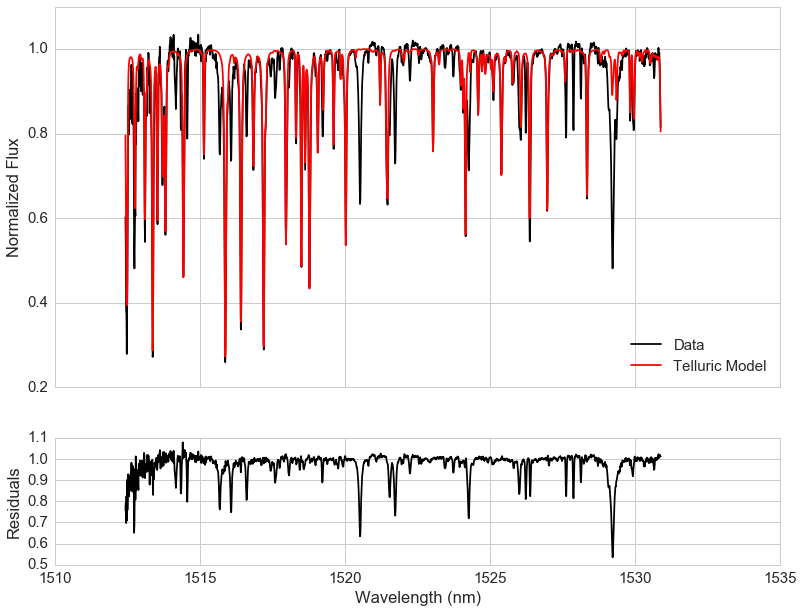

In [18]:
newdata3 = fitter.data
newdata3.y *= source.y

fig, (top, bottom) = plt.subplots(2, 1, sharex=True, figsize=(13, 10), 
                                  gridspec_kw=dict(height_ratios=(3,1)))

top.plot(newdata3.x, newdata3.y/newdata3.cont, 'k-', label='Data')
top.plot(model3.x, model3.y, 'r-', label='Telluric Model')
bottom.plot(newdata3.x, newdata3.y/newdata3.cont / model3.y, 'k-')
#bottom.plot(newdata.x, newdata.y/newdata.cont / model.y, 'r-', alpha=0.7, lw=0.8)

bottom.set_xlabel('Wavelength (nm)')
bottom.set_ylabel('Residuals')
top.set_ylabel('Normalized Flux')

leg = top.legend(loc='best', fancybox=True)

Success! The telluric residuals are for the most part unnoticable and you can now proceed to measure radial velocities, metallicities, etc...